In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

In [2]:
games = pd.read_csv("Video_Games.csv", header=None, names = ['item', 'user', 'rating', 'timestamp'])

In [3]:
games

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400
...,...,...,...,...
2565344,B01HJEBIAA,ANGB54K3888S4,5.0,1533081600
2565345,B01HJEBIAA,A3TEVKR0ZVQB2T,5.0,1531785600
2565346,B01HJEBIAA,ABE7YPWEHNVJZ,5.0,1530835200
2565347,B01HJEBIAA,A3ES9QBK3G192O,5.0,1528761600


In [4]:
len(games['item'].unique()), len(games['user'].unique())

(71982, 1540618)

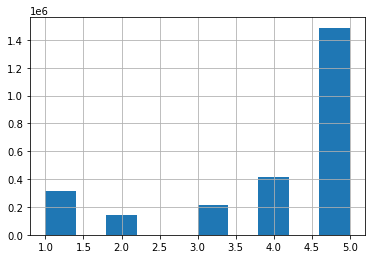

In [5]:
games['rating'].hist()

In [6]:
games['time'] = [datetime.fromtimestamp(i) for i in games['timestamp']]
games.drop(['timestamp'], axis = 1, inplace = True)

In [7]:
games = games.sort_values(['user', 'time']).reset_index()
#games['index'] = range(games.shape[0])
#games = games.set_index('index')

In [8]:
games

,index,item,user,rating,time
0,964569,B0053BCP40,A0002090WKEMAO8KOWKM,5.0,2013-09-25 08:00:00
1,1700163,B00ND0E604,A0002090WKEMAO8KOWKM,5.0,2014-12-03 08:00:00
2,1430577,B00FWK8UWI,A0003214FKMKJE0PCW3D,5.0,2014-10-29 08:00:00
3,1894725,B00ZJRHSRW,A0003492LQH8LJXPWDMZ,3.0,2018-04-27 08:00:00
4,1165426,B00AAS888S,A0005622E33Y7RCVKKVN,5.0,2015-10-19 08:00:00
...,...,...,...,...,...
2565344,2070370,B01C93CWSI,AZZYR0PRM4RBT,5.0,2017-01-02 08:00:00
2565345,2423004,B00BR0Q0GK,AZZZ9DDUPKNKC,3.0,2013-07-15 08:00:00
2565346,13090,B00000K2R4,AZZZEWADNFNUM,4.0,2001-08-10 08:00:00
2565347,1384221,B00ENFVJJO,AZZZOLOP9ZO8B,5.0,2018-05-08 08:00:00


In [9]:
number = []
current = 1
more_two = []
x_train = []
x_test = []
y_train = []
y_test = []
for i in tqdm(range(games.shape[0])):
    if i ==0:
        continue
    if games.loc[i, 'user'] == games.loc[i - 1, 'user']:
        current = current + 1 
    else:
        number.append(current)
        if current > 1:
            all_purchases_current_customer = games.loc[i-current:i-1]
            idx = int(len(all_purchases_current_customer) * 0.7)
            for j in all_purchases_current_customer.index:
                if j  < idx + all_purchases_current_customer.index.min():
                    x_train.append({'item': all_purchases_current_customer.loc[j,'item'], 'user':
                                   all_purchases_current_customer.loc[j,'user']})
                    y_train.append({'rating': all_purchases_current_customer.loc[j,'rating']})
                else:
                    x_test.append({'item': all_purchases_current_customer.loc[j,'item'], 'user':
                                   all_purchases_current_customer.loc[j,'user']})
                    y_test.append({'rating': all_purchases_current_customer.loc[j,'rating']})
        current = 1

        

100%|█████████████████████████████████████████████████████████████████████| 2565349/2565349 [03:29<00:00, 12223.83it/s]


In [10]:
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

In [11]:
x_train

,item,user
0,B0053BCP40,A0002090WKEMAO8KOWKM
1,B00AAS888S,A0005622E33Y7RCVKKVN
2,B00JF63SQI,A0005622E33Y7RCVKKVN
3,B0013E9HP6,A00065507CNSR8UHQFCK
4,B009NAVOMG,A0009060FA8P413511WS
...,...,...
846528,B01BYKK1PI,AZZWWSMIDFU6S
846529,B00AW6M8I4,AZZX21LHCW3HD
846530,B0069EB9CY,AZZX40NRMUDDQ
846531,B007MJSZDQ,AZZX40NRMUDDQ


In [12]:
x_train['rating'] = y_train['rating']

In [13]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy

In [14]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(x_train[['user', 'item', 'rating']], reader)
algo = SVD()
trainset = data.build_full_trainset()
algo = algo.fit(trainset)

In [15]:
x_test['rating'] = y_test['rating']
users = x_test.user.values
items = x_test.item.values
ratings = x_test.rating.values
test_data = []
for i in range(len(users)):
    test_data.append((users[i], items[i], ratings[i]))

In [16]:
predictions = algo.test(test_data)
accuracy.rmse(predictions)

RMSE: 1.1715


1.171494296832656